# Generate Approximate Hessians
Like the previous notebook, fit an approximate model and use that to compute the Hessian. Instead of treating the Hessian parameters as separate, we try here to fit a forcefield using the data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.dscribe.local import make_gpr_model, train_model, DScribeLocalCalculator, DScribeLocalEnergyModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from dscribe.descriptors.soap import SOAP
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
from io import StringIO
import pandas as pd
import numpy as np
import warnings
import torch
import json
import ase

Configuration

In [2]:
db_path = '../1_explore-sampling-methods/data/along-axes/caffeine_pm7_None_d=5.00e-03-N=2.db'
device = 'cuda'

Derived

In [3]:
run_name, sampling_options = Path(db_path).name[:-3].rsplit("_", 1)
exact_path = Path('../data/exact/') / f'{run_name}-ase.json'
sampling_name = Path(db_path).parent.name
out_name = '_'.join([run_name, sampling_name, sampling_options])

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [4]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 5185 structures


Read in the exact Hessian

In [5]:
with open(exact_path) as fp:
    exact_vibs = VibrationsData.read(fp)

In [6]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()

## Start by Adjusting Hyperparameters
There are many layers of things we can adjust with SOAP, including
- The descriptors which are used. SOAP has at least 3 main adjustable parameters
- The complexity of the GPR model, which is mainly varied by the number of inducing points (more points -> more complexity)
- How the model is trained: E.g., batch size, learning rate

Here, we adjust them for our particular problem and start with the descriptors. 

We'll start from a reasonable guess for all then tweak each

In [7]:
train_data, test_data = train_test_split(data, test_size=0.1)

Get a baseline score

In [8]:
test_y = np.array([a.get_potential_energy() for a in test_data])
baseline_y = np.abs(test_y - test_y.mean()).mean()
print(f'Baseline score: {baseline_y*1000:.2e} meV')

Baseline score: 5.61e-01 meV


Make a model testing function

In [9]:
def test_soap_model(train_data: list[ase.Atoms],
                    test_data: list[ase.Atoms],
                    soap: SOAP,
                    num_inducing_points: int,
                    train_steps: int,
                    batch_size: int,
                    learning_rate: float,
                    fit_inducing_points: bool = False,
                    device: str = 'cpu',
                    verbose: bool = False):
    """Train a model then evaluate on a test set
    
    Args:
        train_data: Training data
        test_data: Test data
        soap: SOAP descriptor computer
        train_steps: Number of training steps
        batch_size: Batch size to use for training
        learning_rate: Learning rate to use for training
        fit_inducing_points: Whether to fit inducing points during training
        device: Device used for training
        verbose: Whether to display progress bar
    Returns:
        - Training curve
        - Predictions on each entry in the test set
        - MAE on the test set
    """
    
    # Prepare the training set, scaling the input
    train_x = soap.create(train_data).astype(np.float32)
    offset_x = train_x.mean(axis=(0, 1))
    train_x -= offset_x
    scale_x = np.clip(train_x.std(axis=(0, 1)), a_min=1e-6, a_max=None)
    train_x /= scale_x
    
    train_y_per_atom = np.array([a.get_potential_energy() / len(a) for a in train_data])
    scale, offset = train_y_per_atom.std(), train_y_per_atom.mean()
    train_y = np.array([(a.get_potential_energy() - len(a) * offset) / scale for a in train_data]).astype(np.float32)
    
    # Make the model and train it
    model = make_gpr_model(train_x, num_inducing_points=num_inducing_points, use_ard_kernel=True)
    model.inducing_x.requires_grad = fit_inducing_points
    log = train_model(model, train_x, train_y, steps=train_steps, batch_size=batch_size, verbose=verbose, learning_rate=learning_rate, device=device)
    
    # Run it on the test set
    calc = DScribeLocalCalculator(model=model, desc=soap, desc_scaling=(offset_x, scale_x), energy_scaling=(offset, scale), device=device)
    test_preds = {'true': [], 'pred': []}
    for atoms in test_data:
        test_preds['true'].append(atoms.get_potential_energy())
        atoms = atoms.copy()
        test_preds['pred'].append(calc.get_potential_energy(atoms))
        
    # Get the MAE
    preds = pd.DataFrame(test_preds)
    mae = (preds['true'] - preds['pred']).abs().mean()
    return log, preds, mae

Determine a good cutoff

In [10]:
species = ['C', 'O', 'N', 'H']
n_max = 4
l_max = 4
cutoffs = np.arange(3., 6.01, 1)
inducing_points = 64
train_steps = 8
test_scores = []
for cutoff in tqdm(cutoffs):
    soap = SOAP(
        species=species,
        n_max=n_max,
        l_max=l_max,
        periodic=False,
        r_cut=cutoff
    )
    log, preds, mae = test_soap_model(train_data, test_data, soap, inducing_points, train_steps=train_steps, batch_size=2, learning_rate=0.01, device=device)
    test_scores.append(mae)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:33<00:00, 23.31s/it]


In [11]:
cutoff = cutoffs[np.argmin(test_scores)]
print(f'Selected a maximum distance of {cutoff:.2f} A. Best score: {min(test_scores)*1000:.2e} meV')

Selected a maximum distance of 6.00 A. Best score: 1.97e-01 meV


Determine a good descriptor complexity. We are going to optimize $n$ and $l$ together for simplicty, but they do describe very different types of orbitals

In [12]:
nl_maxes = range(1, 7)
test_scores = []
for nl_max in tqdm(nl_maxes):
    soap = SOAP(
        species=species,
        n_max=nl_max,
        l_max=nl_max,
        periodic=False,
        r_cut=cutoff
    )
    log, preds, mae = test_soap_model(train_data, test_data, soap, inducing_points, train_steps=train_steps, batch_size=2, learning_rate=0.01, device=device)
    test_scores.append(mae)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:52<00:00, 28.77s/it]


In [13]:
nl_max = nl_maxes[np.argmin(test_scores)]
print(f'Selected a complexity of {nl_max}. Best score: {min(test_scores)*1000:.2e} meV')

Selected a complexity of 6. Best score: 1.79e-01 meV


Determine a good model complexity, increaseing the number of steps to allow more complex models to train effectively

In [14]:
inducing_pointss = [32, 64, 128, 256, 512]
train_steps *= 2
test_scores = []
for inducing_points in tqdm(inducing_pointss):
    soap = SOAP(
        species=species,
        n_max=nl_max,
        l_max=nl_max,
        periodic=False,
        r_cut=cutoff
    )
    log, preds, mae = test_soap_model(train_data, test_data, soap, inducing_points, train_steps=train_steps, batch_size=2, learning_rate=0.01, device=device)
    test_scores.append(mae)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [12:13<00:00, 146.69s/it]


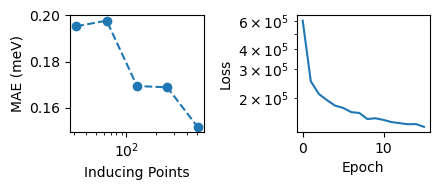

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.))

ax = axs[0]
ax.semilogx(inducing_pointss, np.multiply(test_scores, 1000), '--o')
ax.set_xlabel('Inducing Points')
ax.set_ylabel('MAE (meV)')

ax = axs[1]
ax.semilogy(log['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

fig.tight_layout()

At least 512 is fine, let's just increase the number of training steps

In [16]:
inducing_points = 512
train_steps = 128

In [17]:
%%time
log, preds, mae = test_soap_model(train_data, test_data, soap, inducing_points, train_steps=train_steps, batch_size=2, learning_rate=0.01, device=device, verbose=True)

CPU times: user 5h 52min 46s, sys: 17min 29s, total: 6h 10min 16s
Wall time: 31min 33s


Plot the learning curve of the final model

In [18]:
print(f'Final MAE: {mae*1000:.2e} meV')

Final MAE: 1.61e-01 meV


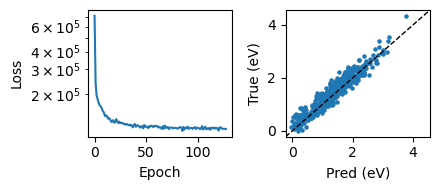

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.))

ax = axs[0]
ax.semilogy(log['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


ax = axs[1]
ax.scatter((preds['pred'] - preds['true'].min()) * 1000,
           (preds['true'] - preds['true'].min()) * 1000, s=5)
ax.set_xlabel('Pred (eV)')
ax.set_ylabel('True (eV)')
ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

fig.tight_layout()

## Fit a Hessian with All Data
Fit a model with the parameters tuned above

In [24]:
model = DScribeLocalEnergyModel(
    reference=data[0],
    model_fn=lambda x: make_gpr_model(x, num_inducing_points=512, use_ard_kernel=True),
    descriptors=soap,
    num_calculators=1,
    device=device,
    train_options=dict(steps=128, batch_size=2, learning_rate=0.01, verbose=True),
)

Plot the model performance

In [25]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hess_models = model.train(data)

CPU times: user 1d 4h 36min 50s, sys: 1h 24min 52s, total: 1d 6h 1min 43s
Wall time: 2h 30min 15s


Compare the forces estimated at a zero displacement to the true value

In [26]:
actual_forces = data[0].get_forces()

In [27]:
pred_forces = hess_models[0].get_forces(data[0])

In [28]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 2.79e-17 eV/Angstrom


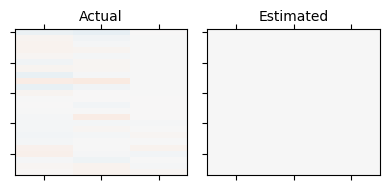

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [30]:
%%time
approx_hessian = model.mean_hessian(hess_models)

CPU times: user 13.5 s, sys: 214 ms, total: 13.7 s
Wall time: 13.6 s


Compare to exact answer

In [31]:
exact_hess[:3, :3]

array([[ 1.42193910e+01,  2.19101005e+01, -2.39586674e-04],
       [ 2.19101005e+01,  7.86328494e+01, -3.46912831e-05],
       [-2.39586674e-04, -3.46912831e-05,  2.52655314e+00]])

In [32]:
approx_hessian[:3, :3]

array([[-5.55912223e-14, -3.93125436e-15, -3.51610438e-17],
       [-3.93125436e-15, -2.08549314e-16, -2.18213076e-17],
       [-3.51610438e-17, -2.18213076e-17,  3.54173454e-20]])

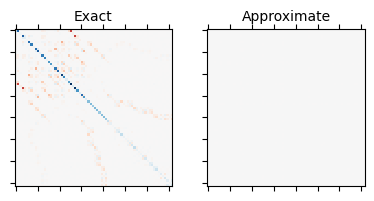

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [34]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [35]:
approx_vibs.get_zero_point_energy()

6.83574459431342e-08

In [36]:
exact_zpe

4.746888516975277

The two differ, but I'm not sure how important the difference is.

Save it to disk

In [37]:
out_dir = Path('data/soap')
out_dir.mkdir(exist_ok=True, parents=True)
with open(f'data/soap/{out_name}.json', 'w') as fp:
    approx_vibs.write(fp)

## Plot as a Function of Data
See what happens as we add more data to the training

In [38]:
model.train_options['verbose'] = False

In [39]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 350, 695, 1041, 1386, ...


In [43]:
zpes = []
vib_data = []
for count in tqdm(steps):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hess_model = model.train(data[:count])
    
    # Compute the approximate Hessian
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    
    # Save a ZPE and the JSON as a summary
    
    zpes.append(approx_vibs.get_zero_point_energy())
    fp = StringIO()
    approx_vibs.write(fp)
    vib_data.append({'count': int(count), 'vib_data': fp.getvalue()})

 25%|████████████████████████████████████████████████████████████                                                                                                                                                                                    | 4/16 [1:14:57<3:44:53, 1124.42s/it]


KeyboardInterrupt: 

In [44]:
with (out_dir / f'{out_name}-incremental.json').open('w') as fp:
    json.dump(vib_data, fp)

Plot it

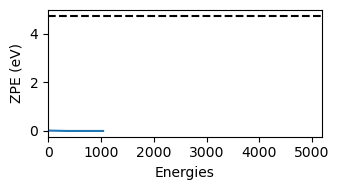

In [45]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps[:len(zpes)], zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()